# 02805 - Social Graphs and Interactions -  Project Assignment B

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import PIL
import networkx as nx
import itertools
from fa2 import ForceAtlas2
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches

from networkx.algorithms import community
import community

import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud


%matplotlib inline

# Motivation

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum

## Basic Stats

In [2]:
# Import data
df = pd.read_csv('all_drinks.csv', encoding = 'utf-8')

# Removes row "Unnamed"
cols = df.columns
cols = cols[1:]
data = np.array(df)[:,1:]
df = pd.DataFrame(np.array(df)[:,1:])
df.columns = cols

df.head()

,strDrink,dateModified,idDrink,strAlcoholic,strCategory,strDrinkThumb,strGlass,strIBA,strIngredient1,strIngredient10,...,strMeasure15,strMeasure2,strMeasure3,strMeasure4,strMeasure5,strMeasure6,strMeasure7,strMeasure8,strMeasure9,strVideo
0,'57 Chevy with a White License Plate,2016-07-18 22:49:04,14029,Alcoholic,Cocktail,http://www.thecocktaildb.com/images/media/drin...,Highball glass,NaN,Creme de Cacao,NaN,...,NaN,1 oz,,,,,,NaN,NaN,NaN
1,1-900-FUK-MEUP,2016-07-18 22:27:04,15395,Alcoholic,Shot,http://www.thecocktaildb.com/images/media/drin...,Old-fashioned glass,NaN,Absolut Kurant,NaN,...,NaN,1/4 oz,1/4 oz,1/4 oz,1/4 oz,1/4 oz,1/2 oz,1/4 oz,,NaN
2,110 in the shade,2016-02-03 14:51:57,15423,Alcoholic,Beer,http://www.thecocktaildb.com/images/media/drin...,Beer Glass,NaN,Lager,NaN,...,NaN,1.5 oz,,,,,,NaN,NaN,NaN
3,151 Florida Bushwacker,2016-07-18 22:28:43,14588,Alcoholic,Milk / Float / Shake,http://www.thecocktaildb.com/images/media/drin...,Beer mug,NaN,Malibu rum,NaN,...,NaN,1/2 oz,1/2 oz Bacardi,1 oz,1 oz,3 oz,1 oz,1 cup,,NaN
4,155 Belmont,2016-10-05 12:36:28,15346,Alcoholic,Cocktail,http://www.thecocktaildb.com/images/media/drin...,White wine glass,NaN,Dark rum,NaN,...,NaN,2 shots,1 shot,1 shot,,,,,,NaN


**Cocktail Data**

The dataset contains 546 rows of each 40 columns. Each row corresponds to a drink, with each column corresponding to features concerning that drink. The most interesting features herein are Category, Glass, and the different ingredients. The data has been retrieved from https://www.kaggle.com/ai-first/cocktail-ingredients.

In [ ]:
print(df.shape)
cols

In [3]:
# Get Categories

categories = np.array(df['strCategory'])
unique_categories, counts = np.unique(categories, return_counts=True)
c = np.asarray((unique_categories, counts)).T
print(c)

[['Beer' 13]
 ['Cocktail' 64]
 ['Cocoa' 9]
 ['Coffee / Tea' 25]
 ['Homemade Liqueur' 12]
 ['Milk / Float / Shake' 17]
 ['Ordinary Drink' 275]
 ['Other/Unknown' 34]
 ['Punch / Party Drink' 37]
 ['Shot' 49]
 ['Soft Drink / Soda' 11]]


*The dataset contains information about drinks from the above-seen categories. The most frequent type of drink is "ordinary drink". The most common ingredients within each category will be displayed by generating WordClouds.*

In [4]:
# Get Ingredients

ingredient_indices = cols[8:23]
ingredients = data[:,8:23]
# Concatenate
ingredients_all = np.concatenate(ingredients)
# Remove empty fields
ingredients_all = [i for i in ingredients_all if isinstance(i, str)]
unique_ingredients, counts = np.unique(ingredients_all, return_counts=True)
print(unique_ingredients[:20])

['151 proof rum' '7-Up' 'Absinthe' 'Absolut Citron' 'Absolut Kurant'
 'Absolut Peppar' 'Absolut Vodka' 'Advocaat' 'Agave Syrup' 'Agave syrup'
 'Ale' 'Allspice' 'Almond' 'Almond flavoring' 'Amaretto' 'Angelica root'
 'Angostura Bitters' 'Angostura bitters' 'Anis' 'Anise']


*Above is seen the first 20 unique ingredients contained within the data-set...*

# Tools, Theory and Analysis

## The Network

In [ ]:
dim = df.shape[0]

# Init graph
G = nx.Graph()
G.add_nodes_from(list(range(dim)))

In [ ]:
# Dictionary containing edges and their corresponding weights
edges = {}

# Loop over ingredients
for ingredient in unique_ingredients:
    # Get indices of rows that have the ingredient
    indices = np.unique(np.where(data[:,8:23] == ingredient)[0])
    # Construct the pairwise combinations of indices
    pairs = list(itertools.combinations(indices, 2))
    for p in pairs:
        if p in edges:
            edges[p] += 1
        else:
            edges[p] = 1
        
for (n1, n2), w in edges.items():
    G.add_edge(n1, n2, weight=w)
    

# Construct a degree vector
d = dict(nx.degree(G))

In [ ]:
sorted_edges = sorted(edges.items(), key=lambda kv: kv[1])
sorted_edges.reverse()
sorted_edges[:10]

In [ ]:
# Init force atlas 2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=4.0,

                        # Performance
                        jitterTolerance=0.01,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.01,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

In [ ]:
# Init color array
cols = np.empty(shape=dim, dtype='<U30')
# List of possible colors
#col_list = cm.rainbow(np.linspace(0,1,len(unique_categories) + 1))
col_list = np.array(['goldenrod', 'orangered', 'chocolate', 'tan', 'purple', 'maroon', 'green', 'dimgrey', 'steelblue', 'y', 'navy'])
#np.random.shuffle(col_list)

for i, c in enumerate(categories):
    j = np.where(unique_categories == c)[0][0]
    cols[i] = col_list[j]


In [ ]:
patches = []
for i, c in enumerate(unique_categories):
    patches.append(mpatches.Patch(color=col_list[i], label=c))

plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[v for v in d.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their total degree.')
    
plt.show()

In [ ]:
b = nx.betweenness_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[30000 * v for v in b.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their betweenness centrality.')
    
plt.show()

In [ ]:
e = nx.eigenvector_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[3000 * v for v in e.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their eigenvector centrality.')
    
plt.show()

# Community Detection

In [ ]:
# Use the Louvain algorithm for community detection
partition = community.best_partition(G)
# Calculate modularity
mod = community.modularity(partition, G)

print('Modularity: {}'.format(mod))

In [ ]:
from matplotlib.pyplot import cm

# Init color array
cols = np.full(shape=(dim, 4), fill_value=1.000000)
# List of possible colors
n_of_communities = max(partition.values())
col_list = cm.rainbow(np.linspace(0,1,n_of_communities + 1))
np.random.shuffle(col_list)

# Save colors according to the partition
for i, p in partition.items():
    cols[i] = col_list[p]

plt.figure(figsize=(20, 10), dpi=100)
nx.draw(G, positions, node_size=[v for v in d.values()], with_labels=False, 
        node_color=cols, edge_color="silver", edge_width=0.5, arrows=False)
plt.title('Visualization of the communities produced by the Louvain algorithm.')
plt.show()

In [ ]:
glass_types = df['strGlass']
glass_types = np.array([s.lower() for s in glass_types])  # Non-case sensitive
unique_glass_types = np.unique(glass_types)
unique_glass_types

com_cat = np.zeros(shape=(n_of_communities + 1, len(unique_categories)), dtype='int')
com_glass = np.zeros(shape=(n_of_communities + 1, len(unique_glass_types)), dtype='int')

for i, p in partition.items():
    category = np.where(unique_categories == categories[i])
    glass_type = np.where(unique_glass_types == glass_types[i])
    com_cat[p][category] += 1
    com_glass[p][glass_type] += 1
    
com_cat = pd.DataFrame(com_cat)
com_cat.columns = unique_categories
com_cat = com_cat.T

com_glass = pd.DataFrame(com_glass)
com_glass.columns = unique_glass_types
com_glass = com_glass.T

In [ ]:
com_cat

In [ ]:
com_glass

In [ ]:
import seaborn as sns; sns.set()

# Relative to rows

cat_row = com_cat.copy()
glass_row = com_glass.copy()

# Relative to cols

cat_col = com_cat.copy()
glass_col = com_glass.copy()

# Relative to cols

cat_cross = com_cat.copy()
glass_cross = com_glass.copy()


In [ ]:
for i in range(cat_row.shape[0]):
    row = np.array(cat_row.iloc[i,:])
    s = np.sum(row)
    cat_row.iloc[i,:] = row / s
    
for i in range(glass_row.shape[0]):
    row = np.array(glass_row.iloc[i,:])
    s = np.sum(row)
    glass_row.iloc[i,:] = row / s

In [ ]:
for i in range(cat_col.shape[1]):
    col = np.array(cat_col.iloc[:,i])
    s = np.sum(col)
    cat_col.iloc[:,i] = col / s
    
for i in range(glass_col.shape[1]):
    col = np.array(glass_col.iloc[:,i])
    s = np.sum(col)
    glass_col.iloc[:,i] = col / s

In [ ]:
for i in range(com_cat.shape[0]):
    for j in range(com_cat.shape[1]):
        col = np.array(com_cat.iloc[:,j])
        row = np.array(com_cat.iloc[i,:])
        s = np.sum(np.concatenate((col, row)))
        cat_cross.iloc[i,j] /= s
    
for i in range(com_glass.shape[0]):
    for j in range(com_glass.shape[1]):
        col = np.array(com_glass.iloc[:,j])
        row = np.array(com_glass.iloc[i,:])
        s = np.sum(np.concatenate((col, row)))
        glass_cross.iloc[i,j] /= s

In [ ]:
s = np.sum(np.array(com_cat))
com_cat /= s
    
s = np.sum(np.array(com_glass))
com_glass /= s

### Heatmap of the communities w.r.t. to the corresponding categories and glass-types. Results are scaled by the total sum of the confusion matrix.


In [ ]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)


sns.heatmap(com_cat, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(com_glass, linewidths = .01, cmap="Blues", ax=axs[1])


### Heatmap of the communities w.r.t. to the corresponding categories and glass-types. Results are scaled by the row-sums of the confusion matrix.

In [ ]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cat_row, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(glass_row, linewidths = .01, cmap="Blues", ax=axs[1])

### Heatmap of the communities w.r.t. to the corresponding categories and glass-types. Results are scaled by the column-sums of the confusion matrix.

In [ ]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cat_col, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(glass_col, linewidths = .01, cmap="Blues", ax=axs[1])

### Heatmap of the communities w.r.t. to the corresponding categories and glass-types. Each element is scaled by sum of elements that are on the same row or column in the confusion matrix.

In [ ]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cat_cross, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(glass_cross, linewidths = .01, cmap="Blues", ax=axs[1])

From the confusion matrix and its visualizations it can be seen that while the communities do not generally correspond to drink categories or glass-types, for some specific categories and glass-types the correlation does indeed exist. 

### Categories

Most prominently, shots are clearly associated with community 1, cocktails, soft drinks, punches and party drinks are associated with community 0 and all cocoa-drinks lie in community 4. An another interesting observations is that while ordinary drinks are most prominently present in community 3, significant quantities lie also in communites 0 and 2. Overall, community 4 seems to be the relatively most populated community for in total five categories: Cocoa, Coffee / Tea, Homemade Liqueur, Milk / Float / Shake and Other/Unknown.

### Glass-types

The most prominent associations:
- Coctail Glass $\rightarrow 3$
- Coffee Mug $\rightarrow 4$
- Collins Glass $\rightarrow 0$
- Martini Glass $\rightarrow 3$
- Mason Jar $\rightarrow 4$
- Pitcher $\rightarrow 4$
- Punch Bowl $\rightarrow 0$
- Shot Glass $\leftrightarrow 1$
- White Wine Glass $\rightarrow 0$

(Here the direction of the arrow denotes the direction of the association.)

In [ ]:
transactions_cat = []
transactions_glass = []

for i, c in partition.items():
    
    category = categories[i]
    glass_type = glass_types[i]
    transactions_cat += [(c, category)]
    transactions_glass += [(c, glass_type)]
    
transactions_cat = np.array(transactions_cat)
transactions_glass = np.array(transactions_glass)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

items_cat = np.unique(transactions_cat)
items_glass = np.unique(transactions_glass)

In [ ]:
def encode(df, items):
    encoded_vals = []
    for index, row in df.iterrows():
        labels = {}
        uncommons = list(set(items) - set(row))
        commons = list(set(items).intersection(row))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    return pd.DataFrame(encoded_vals)

In [ ]:
df_cat = pd.DataFrame(transactions_cat)
df_glass = pd.DataFrame(transactions_glass)

ohe_cat = encode(df_cat, items_cat)
ohe_glass = encode(df_glass, items_glass)

In [ ]:
# min_support=0.002 filters out the 1-observation communities

freq_items_cat = apriori(ohe_cat, min_support=0.002, use_colnames=True, verbose=1)
freq_items_glass = apriori(ohe_glass, min_support=0.002, use_colnames=True, verbose=1)

In [ ]:
rules_cat = association_rules(freq_items_cat, metric="confidence", min_threshold=0.5)
rules_cat

In [ ]:
rules_glass = association_rules(freq_items_glass, metric="confidence", min_threshold=0.5)
rules_glass

Association rule mining performed on the partition data (with filtering out itemsets with less than 0.002 support, i.e. one-observation communities) seems to conduct somewhat similar results as the analysis of confusion matrix/heatmaps in terms of the most relevant associations. It is noteworthy, however, that the association rules represented here are directional, while relevance of an association, in this context, isn't necessarily defined only by strength of an one directional mapping but should rather reflect the strength of a bidirectional mapping. Next we construct wordclouds for each community to better understand the underlying characteristics of these communities.

# WordClouds

In [5]:
punctuation = string.punctuation + '…'

def map_punctuation(s):
    return np.array([char not in punctuation for char in s])

token_arrays = np.empty(len(unique_categories),object)
token_arrays.fill([])

In [6]:
# Cleaning DataFrame for multiple instances of same glass type:

df2 = df.copy()

for i, row in df2.iterrows():
    
    row['strGlass'] = row['strGlass'].lower()
    
    if (row['strGlass'] == 'beer mug') or (row['strGlass'] == 'beer pilsner'):
        row['strGlass'] = 'beer glass'
        
    if row['strGlass'] == 'margarita glass':
        row['strGlass'] = 'margarita/coupette glass'
        
    if row['strGlass'] == 'white wine glass':
        row['strGlass'] = 'wine glass'
        
data2 = np.array(df2)

# We extract the list of unique glass types after we have cleaned:

unique_glasses = []
glasses = np.array(df2['strGlass'])

unique_glasses_temp, counts_temp = np.unique(glasses, return_counts=True)
c = np.asarray((unique_glasses_temp, counts_temp)).T

for i in range(len(unique_glasses_temp)):
    if counts_temp[i] > 7:                #Only including glasstype of occuring over 7 times
        unique_glasses.append(unique_glasses_temp[i])


unique_glasses = np.array(unique_glasses)
unique_glasses

array(['beer glass', 'champagne flute', 'cocktail glass', 'coffee mug',
       'collins glass', 'highball glass', 'old-fashioned glass',
       'punch bowl', 'shot glass', 'whiskey sour glass', 'wine glass'],
      dtype='<U19')

## Instructions-Glasstype

In [7]:
# Glass types is found in column 6

for i, row in enumerate(data2):
    if row[6] in unique_glasses:
        glass_i = np.where(unique_glasses == row[6])[0][0] # This line finds which index in unique_glasses, this is
        s = row[23] # s is the instruction
        if isinstance(s, str):
            tokens = word_tokenize(s)
            # Remove Numbers:
            tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
            # Remove Punctuation:
            tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
            # Remove Stopwords:
            tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
            for token in tokens:
                token_arrays[glass_i] = np.append(token_arrays[glass_i], token)          

In [8]:
# We now have an array of arrays. Each array corresponds to a glass-type in unique_glasses
# I.e. token_arrays[0] corresponds to all the words in Instructions for unique_glasses[0] which is "Beer Glass"

token_arrays[0]

array(['drop', 'shooter', 'glass', 'fill', 'beer', 'combine',
       'ingredients', 'blend', 'smooth', 'garnish', 'chocolate',
       'shavings', 'desired', 'fill', 'glass', 'ice', 'fish', 'add',
       'vodka', 'grape', 'soda', 'orange', 'juice', 'do', 'not', 'stir',
       'serve', 'well', 'chilled', 'carefully', 'avoid', 'explosive',
       'head', 'formation', 'pour', 'beer', 'glass', 'half', 'full',
       'favorite', 'rootbeer', 'top', 'guinness', 'scoop', 'two', 'large',
       'scoops', 'vanilla', 'frosted', 'beer', 'mug', 'next', 'add',
       'ounces', 'maker', 'mark', 'then', 'pour', 'coke', 'gently',
       'stir', 'enjoy', 'pour', 'corona', 'beer', 'glass', 'pour',
       'bacardi', 'limon', 'beer', 'stir', 'gently', 'blend', 'together',
       'blender', 'serve', 'chilled', 'beer', 'mug', 'fresh',
       'blueberries', 'caramel', 'topping', 'use', 'oz', 'glass', 'add',
       'campari', 'first', 'fill', 'beer', 'pour', 'corona', 'beer',
       'glass', 'pour', 'rum', 'bee

In [9]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))

In [10]:
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
tf_idfs[0][:10]

[('beer', 0.05532072847436888),
 ('bottle', 0.03629228870069823),
 ('corona', 0.03062919662230074),
 ('turn', 0.014516915480279292),
 ('mug', 0.011064145694873776),
 ('whisky', 0.01020973220743358),
 ('unplug', 0.01020973220743358),
 ('thumb', 0.01020973220743358),
 ('specific', 0.01020973220743358),
 ('real', 0.01020973220743358)]

In [11]:
# Create Masks

response_beer = requests.get('https://c7.uihere.com/files/898/72/993/carlsberg-group-beer-glasses-copenhagen-beer.jpg')
mask_beer = np.array(PIL.Image.open(BytesIO(response_beer.content)))

response_champagne = requests.get('http://clipartbarn.com/wp-content/uploads/2016/12/Champagne-glass-champagne-january-clipart-kid.jpg')
mask_champagne = np.array(PIL.Image.open(BytesIO(response_champagne.content)))
    
response_cocktail = requests.get('https://carlisletheacarlisletheatre.org/images/martini-glass-clipart-wine-2.png')
mask_cocktail = np.array(PIL.Image.open(BytesIO(response_cocktail.content)))

In [12]:
use_masks = True

wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)
    
    if use_masks:
        if unique_glasses[i] == 'beer glass':
            wordcloud = WordCloud(collocations=False, mask=mask_beer, background_color='white', width=1000, height=1000).generate(str1)
        elif unique_glasses[i] == 'champagne flute':
            wordcloud = WordCloud(collocations=False, mask=mask_champagne, background_color='white', width=1000, height=1000).generate(str1)
        elif unique_glasses[i] == 'cocktail glass':
            wordcloud = WordCloud(collocations=False, mask=mask_cocktail, background_color='white', width=1000, height=1000).generate(str1)
        else:
            wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
            
    else: 
        wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
        
    wordclouds.append(wordcloud)
    
    print(unique_glasses[i])

beer glass
champagne flute
cocktail glass
coffee mug
collins glass
highball glass
old-fashioned glass
punch bowl
shot glass
whiskey sour glass
wine glass


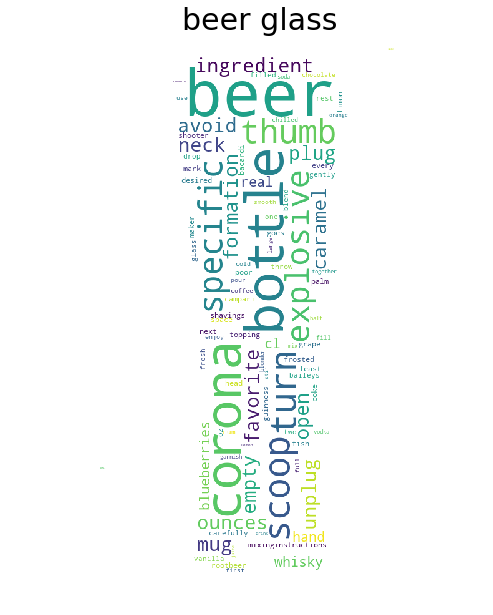

In [15]:
# Plot the wordclouds with masks

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[0]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_glasses[0], fontsize=30)

plt.show() 

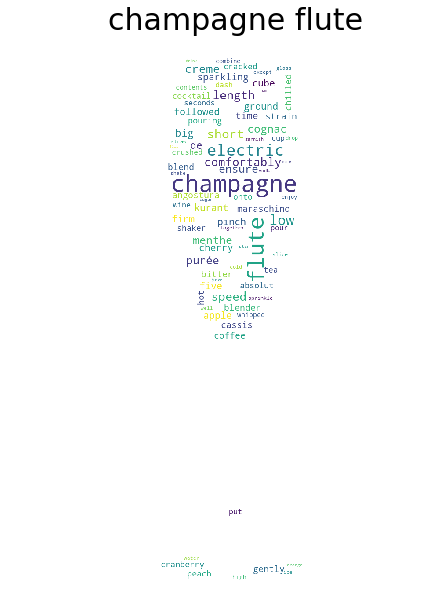

In [16]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[1]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_glasses[1], fontsize=30)

plt.show() 

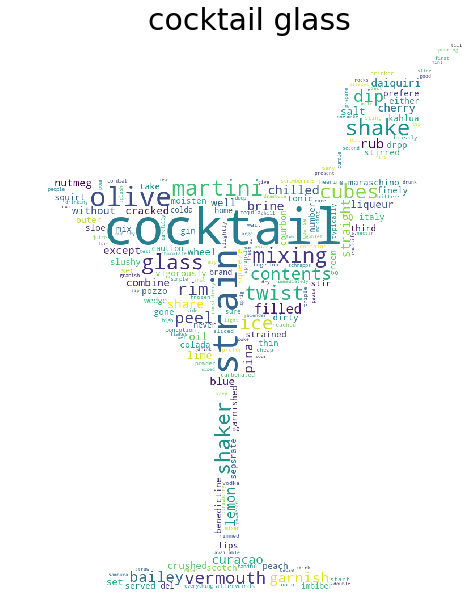

In [17]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[2]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(unique_glasses[2], fontsize=30)

plt.show() 

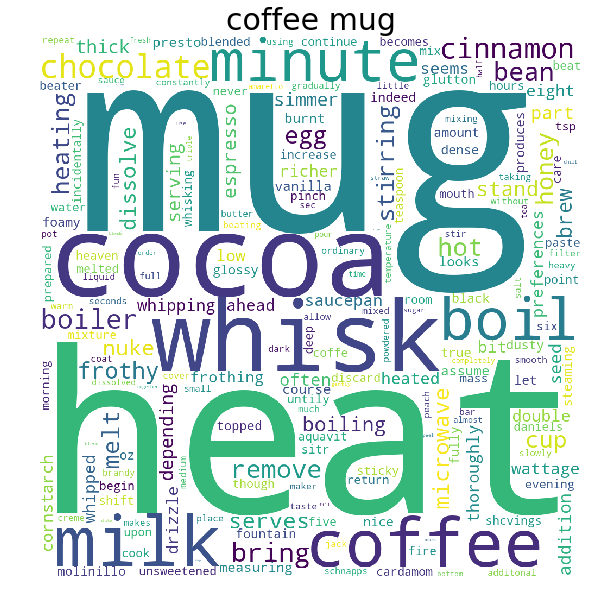

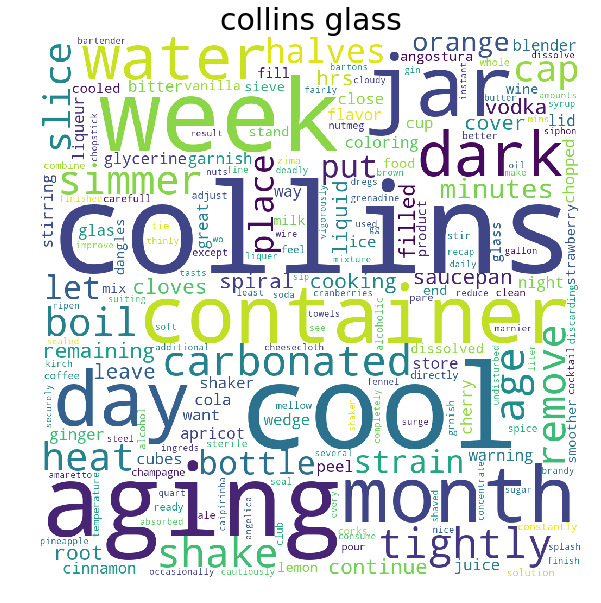

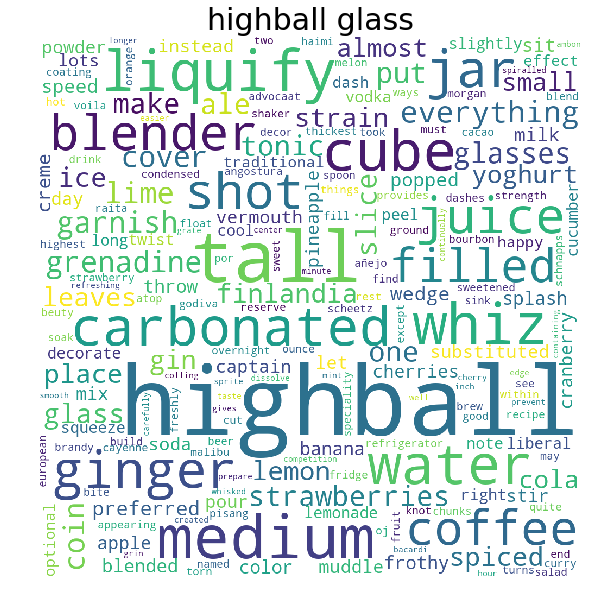

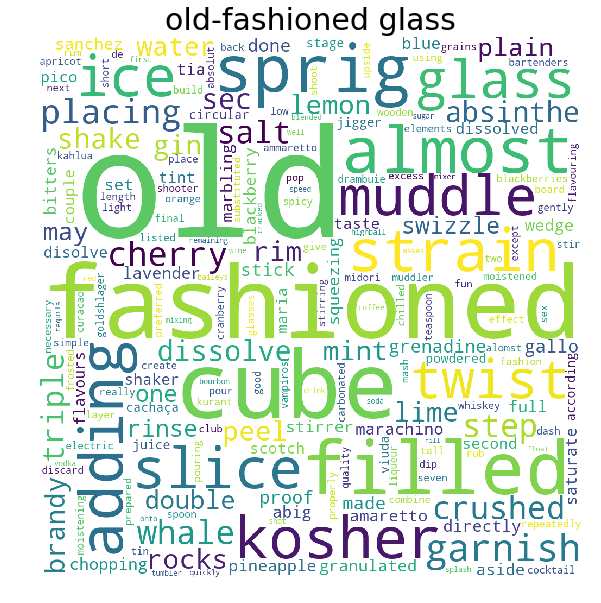

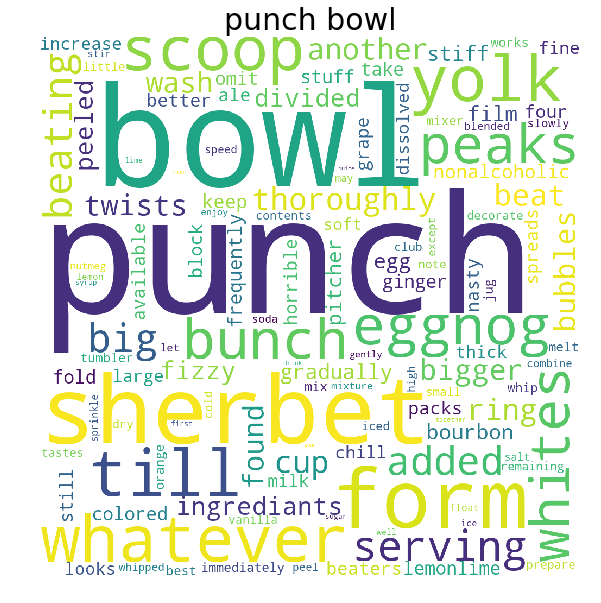

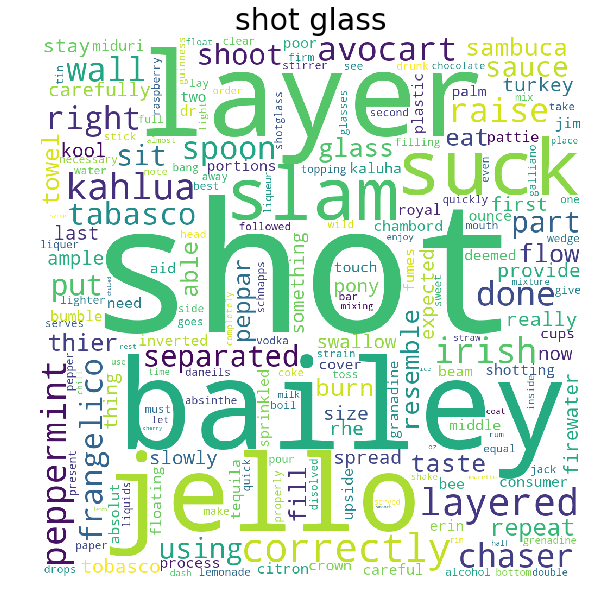

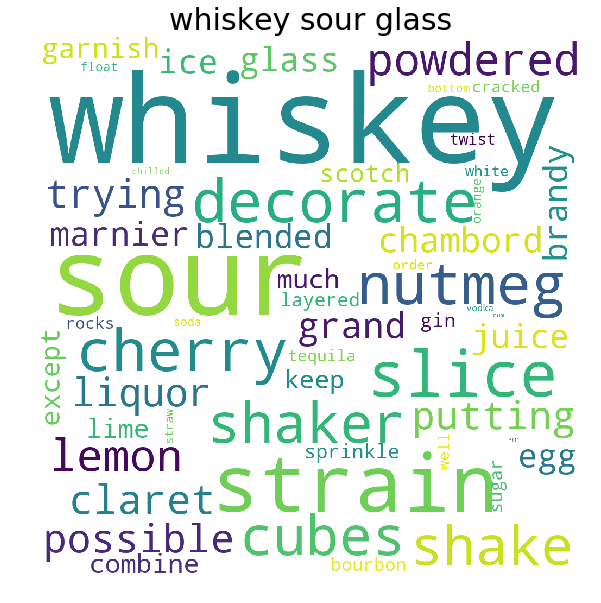

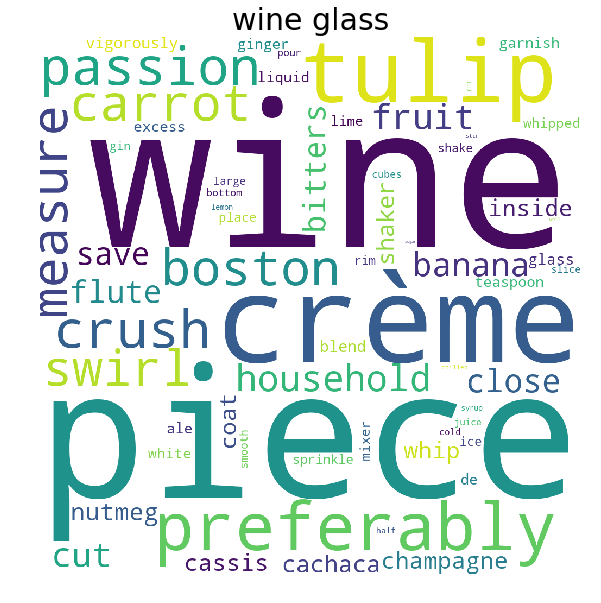

In [14]:
# Plot the rest

for i in range(3, len(unique_glasses)):

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordclouds[i]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(unique_glasses[i], fontsize=30)

    plt.show() 

## Instructions-Category

In [ ]:
unique_categories

In [ ]:
token_arrays = np.empty(len(unique_categories),object)
token_arrays.fill([])

for row in data:
    cat_i = np.where(unique_categories == row[4])[0][0]
    s = row[23]
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[cat_i] = np.append(token_arrays[cat_i], token)
    

In [ ]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))
    
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
tf_idfs[0][:10]

In [ ]:
wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
    wordclouds.append(wordcloud)
    
    print(unique_categories[i])


In [ ]:
for i in range(len(unique_categories)):

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordclouds[i]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(unique_categories[i], fontsize=30)

    plt.show() 

## Ingredients-Categories

In [ ]:
# Ingredients is extracted and joined together.

for i, row in enumerate(data):
    cat_i = np.where(unique_categories == row[4])[0][0] # This line finds which index in unique_categories, this is. row[4] is the category in the row
    s = ingredients[i] # s is the ingredients
    s = [i for i in s if isinstance(i, str)]
    s = ' '.join(s)
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[cat_i] = np.append(token_arrays[cat_i], token)

In [ ]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))
    
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
    

wordclouds = []
for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
    wordclouds.append(wordcloud)
    
    print(unique_categories[i])


In [ ]:
for i in range(len(unique_categories)):

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordclouds[0]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(unique_categories[0], fontsize=30)

    plt.show() 